In [45]:
from sklearn.datasets import fetch_20newsgroups
from typing import Dict
import json
import logging

from overrides import overrides

import tqdm

from allennlp.common import Params
from allennlp.common.file_utils import cached_path
from allennlp.data.dataset_readers.dataset_reader import DatasetReader
from allennlp.data.fields import LabelField, TextField
from allennlp.data.instance import Instance
from allennlp.data.tokenizers import Tokenizer, WordTokenizer
from allennlp.data.token_indexers import TokenIndexer, SingleIdTokenIndexer
from allennlp.data import Vocabulary
from allennlp.data.dataset import Batch
import cytoolz
from torch.autograd import Variable
from datetime import datetime
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.calibration import CalibratedClassifierCV,calibration_curve
from sklearn.feature_extraction.text import CountVectorizer
import json
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
import cytoolz
import scipy.sparse as sp
from sklearn import linear_model
import matplotlib.pyplot as plt
import random
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from prodigy.components.loaders import JSONL

# Define the Model

In [5]:
class FastText(nn.Module):
    """
    FastText model that implements https://arxiv.org/abs/1607.01759
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(FastText, self).__init__()
        # Note that the # of inputs dimension for embedding shall be vocab_size+1, why?
        # In the embedding, you need to set the padding_dx argument.
        # Please see http://pytorch.org/docs/master/nn.html
        print("FastText Model")
        self.embeds = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, data, length):
        """
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        
        all_embs = self.embeds(data)
        sum_emb = torch.sum(all_embs, 1)
        # Note that instead of doing tensorwise mean, you need to calculate the sum and divide by the sentence length
        # in the length tensor.
        avg_emb = sum_emb / length.float().view(-1,1)
        out = self.linear(avg_emb)
        out = self.sigmoid(out.view(-1))
        return out

# Data Process

In [2]:
cats = ['comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware']
newsgroups_train = fetch_20newsgroups(subset='train', categories=cats)
newsgroups_test = fetch_20newsgroups(subset='test',categories=cats)

In [7]:
def parse_jsonl(file_path =None,data=None):
    if file_path:
        data = list(JSONL(file_path))
        print("data size: ", len(data))
    text = []
    label = []
    for item in data:
        text.append(item['text'])
        label.append(1 if item['answer'] == "accept" else 0)
    return text,label

def remove_overlap(old_train_data,old_train_label,test_data):
    old_train = list(zip(old_train_data,old_train_label))
    overlap = 0
    new_train_data = []
    new_train_label = []
    for data in old_train:
        if(data[0] in test_data):
            overlap += 1
        else:
            new_train_data.append(data[0])
            new_train_label.append(int(data[1]))
    print("overlap: ",overlap)
    print("new data size: ",len(new_train_data))
    return new_train_data, new_train_label

def change_ratio(data,label,ratio,size):
    # ratio= positive : negative
    array = np.array(list(zip(data,label)))
    pos = array[array[:,1] == "1",:]
    neg = array[array[:,1] == "0",:]
    print("original pos size: ", len(pos), "\t original neg size: ",len(neg),"\t original data size: ",len(array))
    pos_num = int(size * ratio//(ratio+1))
    neg_num = int(size //(ratio + 1))
    print("pos size: ",pos_num,"\t neg size: ", neg_num,"\t final total size; ",pos_num+neg_num)
    if(len(pos) >= pos_num and len(neg) >= neg_num):
        pos_sample = random.sample(pos.tolist(),pos_num)
        neg_sample = random.sample(neg.tolist(),neg_num)
        result_sample = pos_sample+neg_sample
        random.shuffle(result_sample)
        data,label = zip(*result_sample)
        label = [int(l) for l in label]
        return data,label
    else:
        print("sample size exceeds data size")
    

def save_sample(data,label,file_path):
    data_jsonl = []
    for i in range(len(data)):
        data_jsonl.append({'text':data[i],'answer':'accept' if label[i] else 'reject'})
    print('save '+str(len(data))+' data to '+ file_path)
    with open(file_path,"w") as f:
        f.write("\n".join([json.dumps(j) for j in data_jsonl]))

def split_data(data,label,ratio,size,file_path):
    array = np.array(list(zip(data,label)))
    pos = array[array[:,1] == "1",:]
    neg = array[array[:,1] == "0",:]
    print("original pos size: ", len(pos), "\t original neg size: ",len(neg),"\t original data size: ",len(array))
    pos_num = int(size * ratio//(ratio+1))
    neg_num = int(size //(ratio + 1))
    print("pos size: ",pos_num,"\t neg size: ", neg_num,"\t final total size; ",pos_num+neg_num)
    if(len(pos) >= pos_num and len(neg) >= neg_num):
        pos_sample = random.sample(pos.tolist(),pos_num)
        neg_sample = random.sample(neg.tolist(),neg_num)
        result_sample = pos_sample+neg_sample
        random.shuffle(result_sample)
        data,label = zip(*result_sample)
        label = [int(l) for l in label]
        rest_sample = [ item  for item in array.tolist() if item[0] not in data]
        rest_data,rest_label = zip(*rest_sample)
        rest_label = [int(l) for l in rest_label]
        save_sample(data,label,file_path[0])
        save_sample(rest_data,rest_label,file_path[1])
    else:
        print("sample size exceeds data size")

In [13]:
save_sample(newsgroups_train.data,newsgroups_train.target,"/data/prodigy/data/newsgroup/newsgroup_all.jsonl")

save 1181 data to /data/prodigy/data/newsgroup/newsgroup_all.jsonl


In [9]:
#@DatasetReader.register("IMDBReader")
class IMDBDatasetReader(DatasetReader):
    """
    Reads a JSON-lines file containing papers from the Semantic Scholar database, and creates a
    dataset suitable for document classification using these papers.
    Expected format for each input line: {"paperAbstract": "text", "title": "text", "venue": "text"}
    The JSON could have other fields, too, but they are ignored.
    The output of ``read`` is a list of ``Instance`` s with the fields:
        title: ``TextField``
        abstract: ``TextField``
        label: ``LabelField``
    where the ``label`` is derived from the venue of the paper.
    Parameters
    ----------
    lazy : ``bool`` (optional, default=False)
        Passed to ``DatasetReader``.  If this is ``True``, training will start sooner, but will
        take longer per batch.  This also allows training with datasets that are too large to fit
        in memory.
    tokenizer : ``Tokenizer``, optional
        Tokenizer to use to split the title and abstrct into words or other kinds of tokens.
        Defaults to ``WordTokenizer()``.
    token_indexers : ``Dict[str, TokenIndexer]``, optional
        Indexers used to define input token representations. Defaults to ``{"tokens":
        SingleIdTokenIndexer()}``.
    """
    def __init__(self,
                 lazy: bool = False,
                 tokenizer: Tokenizer = None,
                 token_indexers: Dict[str, TokenIndexer] = None) -> None:
        super().__init__(lazy)
        self._tokenizer = tokenizer or WordTokenizer()
        self._token_indexers = token_indexers or {"tokens": SingleIdTokenIndexer()}

    @overrides
    def _read(self, file_path):
#         content = JSONL(file_path)
#         for line in content:
        with open(cached_path(file_path), "r") as data_file:
#             logger.info("Reading instances from lines in file at: %s", file_path)
            for line in data_file:
                line = line.strip("\n")
                if not line:
                    continue
                review = json.loads(line)
                text = review['text']
                if('label' in review.keys() and 'answer' in review.keys()):
                    label = 1 if (review['label'] == "POSITIVE" and review['answer'] == "accept") or (review['label']=='NEGATIVE' and review['answer'] == 'reject') else 0
                elif ('answer' in review.keys()):
                    label = 1 if review['answer'] == "accept" else 0
                else:
                    label = 1 if review['meta']['label_answer'] == "POSITIVE" else 0
                yield self.text_to_instance(text,label)

    @overrides
    def text_to_instance(self, text: str, label: int) -> Instance:  # type: ignore
        # pylint: disable=arguments-differ
        tokenized_text = self._tokenizer.tokenize(text)
        text_field = TextField(tokenized_text, self._token_indexers)
        
        fields = {'text': text_field, 'length':LabelField(text_field.sequence_length(),skip_indexing=True),'label': LabelField(label,skip_indexing=True)}
        
        return Instance(fields)

    @classmethod
    def from_params(cls, params: Params) -> 'SemanticScholarDatasetReader':
        lazy = params.pop('lazy', False)
        tokenizer = Tokenizer.from_params(params.pop('tokenizer', {}))
        token_indexers = TokenIndexer.dict_from_params(params.pop('token_indexers', {}))
        params.assert_empty(cls.__name__)
        return cls(lazy=lazy, tokenizer=tokenizer, token_indexers=token_indexers)

def build_instance(file_path):
    # tokenize, stem, 
    datareader = IMDBDatasetReader()
    instance = datareader.read(file_path)
    return instance

def build_vocabulary(instance):
    # buil vocabulary
    vocab = Vocabulary.from_instances(instance)
    print("vocab_size:",vocab.get_vocab_size())
    return vocab

def batchify(instance,vocab,batch_size = 32,lstm_flag = False,cuda_device = 0):
    # tensorize, padding, batchify
    batch_loader = []
    for batch in cytoolz.partition_all(batch_size,tqdm.tqdm(instance, leave=False)):
        batch = Batch(batch)
        batch.index_instances(vocab)
        if lstm_flag:
            tensors = batch.as_tensor_dict(batch.get_padding_lengths(),cuda_device)
            tensors = batch.as_tensor_dict({'text': {'num_tokens': int(torch.sum(tensors['length'])/batch_size)}},cuda_device)
        else:
            tensors = batch.as_tensor_dict(batch.get_padding_lengths(),cuda_device)
        batch_loader.append(tensors)
    return batch_loader

def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for batch_idx,batch in enumerate(loader):
        data_batch = Variable(batch['text']['tokens'])
        labels = batch['label']
        length_batch = Variable(batch['length'])
        outputs = model(data_batch, length_batch)
        predicted = (outputs.data > 0.5).long().view(-1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    model.train()
    return (100 * correct / total)

# add Glove pretrained Embedding
def glove():
    word2vec = {}
    print("Load Glove")
    with open('glove.6B.300d.txt', 'r') as f:
        for l in f:
            line = l.split()
            word = line[0]
            word2vec[word] = np.array(line[1:]).astype(np.float)
    #word2vec = pickle.load(open("/liveperson/data/alloy/prodigy/data/6B.300_vec.pkl", 'rb'))
    matrix_len = vocab.get_vocab_size()
    weights_matrix = np.zeros((matrix_len, 300))
    words_found = 0
    for i, word in vocab.get_index_to_token_vocabulary().items():
        try: 
            weights_matrix[i] = word2vec[word]
            words_found += 1
        except KeyError:
            weights_matrix[i] = np.random.normal(scale=0.6, size=(300, ))
    print(words_found,"of ",matrix_len, "have pretrained vectors")
    return weights_matrix

# Cumulative Train

In [84]:
def single_train(model,train_loader,test_loader,n_iter,vocab_size,emb_dim,learning_rate,data_size,batch_size,weights_matrix=None,freeze_emb=False):
    if weights_matrix is not None:
        model.embeds.weight.data.copy_(torch.from_numpy(weights_matrix))
        # check using cuda and do initialization.
        # print(model.embeds.weight.data[0])
        # print(weights_matrix[0])
        print("Use pretrained embeddding")
    else:
        print("No pretrained embedding")
    if freeze_emb:
        model.embeds.weight.requires_grad = False
        print("Freeze embedding layer")
    else:
        print("embedding weight is trainable")
    print("n_iter: ",n_iter)
    print("vocab_size",vocab_size)
    print("emb_dim: ",emb_dim)
    print("learning_rate: ",learning_rate)
    print("batch_size: ",batch_size)
    print("train data size",data_size)
    print(model.parameters())
    criterion = nn.BCELoss()  
    #criterion = nn.NLLLoss()
    #criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()), lr=learning_rate) 
    start_time = datetime.now()
    step_idx = 0
    acc_list = []
    for i in range(n_iter):
        for batch_idx,batch in enumerate(train_loader):
            # Variable defined here or outside iteration?
            data_batch = Variable(batch['text']['tokens'])
            label_batch = Variable(batch['label'])
            length_batch = Variable(batch['length'])
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch.float())
            #model.train()
            #loss.backward(retain_graph=True)
            loss.backward()
            optimizer.step()
        acc = test_model(test_loader,model)
        end_time = datetime.now() -start_time
        print('Time:[{0} seconds], batch: [{1}/{2}], Epoch: [{3}/{4}], step: [{5}/{6}], Loss: {7},Acc:{8}'.format(
                end_time.seconds,batch_idx, data_size//batch_size, i+1, n_iter, step_idx+1, data_size*n_iter//batch_size, loss, acc))
#             step_idx += 1
        acc_list.append([data_size, i+1,loss,acc])

    return acc_list,model
def cumulate_train(train_data,test_data,interval,n_iter,batch_size,emb_dim,learning_rate,cuda_device):
    batch_number = len(train_data)//batch_size
    result = []
    train_loader = batchify(train_data,vocab,batch_size,False,cuda_device)
    test_loader = batchify(test_data,vocab,batch_size,False,cuda_device)
    for fac in np.arange(interval,batch_number+interval,interval):
        train_fac_loader = train_loader[:fac]
        train_fac_size = fac*batch_size
        model = FastText(vocab.get_vocab_size(), emb_dim)
        acc,model = single_train(model,train_fac_loader,test_loader,n_iter,vocab.get_vocab_size(),emb_dim,learning_rate,train_fac_size,batch_size)
        result.append(np.array(acc))
    return result

def plot_cumulate(model,label,x,y,interval,n_iter):
    result = cumulate_train(model,x,y,interval,n_iter)
    plot_result = np.array(result).reshape((len(result),n_iter,3))
    plt.plot(plot_result[:,-1,0],np.max(plot_result[:,:,-1],1),label=label)
    plt.title("Cumulate "+model)
    plt.legend()
    return plot_result

In [14]:
all_data = build_instance("/data/prodigy/data/newsgroup/newsgroup_all.jsonl")
vocab = build_vocabulary(all_data)
baseline_data = build_instance("/data/prodigy/data/newsgroup/newsgroup_train.jsonl")
test_data = build_instance("/data/prodigy/data/newsgroup/newsgroup_test.jsonl")
weights_matrix = glove()

1181it [00:09, 118.29it/s]
100%|██████████| 1181/1181 [00:00<00:00, 2041.24it/s]
23it [00:00, 224.75it/s]

vocab_size: 50966


749it [00:07, 99.19it/s] 
400it [00:02, 156.10it/s]


Load Glove
7683 of  50966 have pretrained vectors


In [21]:

no_active = cumulate_train(baseline_data,test_data,interval=3,n_iter=20,batch_size=32,emb_dim=300,learning_rate=0.01,cuda_device=-1)

FastText Model
No pretrained embedding
embedding weight is trainable
n_iter:  20
vocab_size 50966
emb_dim:  300
learning_rate:  0.01
batch_size:  32
train data size 96
<generator object Module.parameters at 0x7f48c4dbcfc0>
Time:[1 seconds], batch: [2/3], Epoch: [1/20], step: [1/60], Loss: 0.5631628036499023,Acc:50
Time:[2 seconds], batch: [2/3], Epoch: [2/20], step: [1/60], Loss: 0.4536905288696289,Acc:50
Time:[3 seconds], batch: [2/3], Epoch: [3/20], step: [1/60], Loss: 0.4273661673069,Acc:50
Time:[4 seconds], batch: [2/3], Epoch: [4/20], step: [1/60], Loss: 0.4090353548526764,Acc:50
Time:[5 seconds], batch: [2/3], Epoch: [5/20], step: [1/60], Loss: 0.3642081320285797,Acc:50
Time:[6 seconds], batch: [2/3], Epoch: [6/20], step: [1/60], Loss: 0.301174134016037,Acc:50
Time:[7 seconds], batch: [2/3], Epoch: [7/20], step: [1/60], Loss: 0.23617108166217804,Acc:50
Time:[8 seconds], batch: [2/3], Epoch: [8/20], step: [1/60], Loss: 0.17932690680027008,Acc:49
Time:[9 seconds], batch: [2/3], Epo

Time:[43 seconds], batch: [11/12], Epoch: [17/20], step: [1/240], Loss: 0.002126221312209964,Acc:67
Time:[46 seconds], batch: [11/12], Epoch: [18/20], step: [1/240], Loss: 0.0019000658066943288,Acc:67
Time:[48 seconds], batch: [11/12], Epoch: [19/20], step: [1/240], Loss: 0.0017094644717872143,Acc:67
Time:[51 seconds], batch: [11/12], Epoch: [20/20], step: [1/240], Loss: 0.0015472201630473137,Acc:67
FastText Model
No pretrained embedding
embedding weight is trainable
n_iter:  20
vocab_size 50966
emb_dim:  300
learning_rate:  0.01
batch_size:  32
train data size 480
<generator object Module.parameters at 0x7f48c4dbc8e0>
Time:[2 seconds], batch: [14/15], Epoch: [1/20], step: [1/300], Loss: 0.6096522808074951,Acc:50
Time:[5 seconds], batch: [14/15], Epoch: [2/20], step: [1/300], Loss: 0.46823540329933167,Acc:50
Time:[8 seconds], batch: [14/15], Epoch: [3/20], step: [1/300], Loss: 0.28866487741470337,Acc:60
Time:[11 seconds], batch: [14/15], Epoch: [4/20], step: [1/300], Loss: 0.1343575417

Time:[45 seconds], batch: [23/24], Epoch: [11/20], step: [1/480], Loss: 0.002348486101254821,Acc:81
Time:[49 seconds], batch: [23/24], Epoch: [12/20], step: [1/480], Loss: 0.0019776823464781046,Acc:81
Time:[53 seconds], batch: [23/24], Epoch: [13/20], step: [1/480], Loss: 0.0016913755098357797,Acc:81
Time:[57 seconds], batch: [23/24], Epoch: [14/20], step: [1/480], Loss: 0.0014645018381997943,Acc:81
Time:[61 seconds], batch: [23/24], Epoch: [15/20], step: [1/480], Loss: 0.001281609176658094,Acc:81
Time:[65 seconds], batch: [23/24], Epoch: [16/20], step: [1/480], Loss: 0.0011318662436679006,Acc:81
Time:[70 seconds], batch: [23/24], Epoch: [17/20], step: [1/480], Loss: 0.0010075352620333433,Acc:81
Time:[74 seconds], batch: [23/24], Epoch: [18/20], step: [1/480], Loss: 0.0009030951769091189,Acc:81
Time:[78 seconds], batch: [23/24], Epoch: [19/20], step: [1/480], Loss: 0.0008144360617734492,Acc:81
Time:[82 seconds], batch: [23/24], Epoch: [20/20], step: [1/480], Loss: 0.0007384851342067122

In [88]:
no_active1 = cumulate_train(baseline_data,test_data,interval=1,n_iter=20,batch_size=32,emb_dim=300,learning_rate=0.01,cuda_device=-1)



FastText Model
No pretrained embedding
embedding weight is trainable
n_iter:  20
vocab_size 50966
emb_dim:  300
learning_rate:  0.01
batch_size:  32
train data size 32
<generator object Module.parameters at 0x7f4650348d58>
Time:[0 seconds], batch: [0/1], Epoch: [1/20], step: [1/20], Loss: 0.7053788304328918,Acc:50
Time:[1 seconds], batch: [0/1], Epoch: [2/20], step: [1/20], Loss: 0.5956932902336121,Acc:50
Time:[2 seconds], batch: [0/1], Epoch: [3/20], step: [1/20], Loss: 0.5066351294517517,Acc:50
Time:[3 seconds], batch: [0/1], Epoch: [4/20], step: [1/20], Loss: 0.4346866309642792,Acc:50
Time:[4 seconds], batch: [0/1], Epoch: [5/20], step: [1/20], Loss: 0.37740135192871094,Acc:50
Time:[5 seconds], batch: [0/1], Epoch: [6/20], step: [1/20], Loss: 0.3328067660331726,Acc:50
Time:[5 seconds], batch: [0/1], Epoch: [7/20], step: [1/20], Loss: 0.29878827929496765,Acc:50
Time:[6 seconds], batch: [0/1], Epoch: [8/20], step: [1/20], Loss: 0.27262505888938904,Acc:50
Time:[7 seconds], batch: [0/1]

Time:[22 seconds], batch: [3/4], Epoch: [18/20], step: [1/80], Loss: 0.0023349449038505554,Acc:56
Time:[23 seconds], batch: [3/4], Epoch: [19/20], step: [1/80], Loss: 0.0020771638955920935,Acc:56
Time:[24 seconds], batch: [3/4], Epoch: [20/20], step: [1/80], Loss: 0.0018799233948811889,Acc:56
FastText Model
No pretrained embedding
embedding weight is trainable
n_iter:  20
vocab_size 50966
emb_dim:  300
learning_rate:  0.01
batch_size:  32
train data size 160
<generator object Module.parameters at 0x7f45aa7e76d0>
Time:[1 seconds], batch: [4/5], Epoch: [1/20], step: [1/100], Loss: 0.5057257413864136,Acc:50
Time:[2 seconds], batch: [4/5], Epoch: [2/20], step: [1/100], Loss: 0.4401439428329468,Acc:50
Time:[4 seconds], batch: [4/5], Epoch: [3/20], step: [1/100], Loss: 0.35563546419143677,Acc:50
Time:[5 seconds], batch: [4/5], Epoch: [4/20], step: [1/100], Loss: 0.26789847016334534,Acc:50
Time:[7 seconds], batch: [4/5], Epoch: [5/20], step: [1/100], Loss: 0.18984830379486084,Acc:50
Time:[8 s

Time:[27 seconds], batch: [7/8], Epoch: [14/20], step: [1/160], Loss: 0.003396580694243312,Acc:57
Time:[28 seconds], batch: [7/8], Epoch: [15/20], step: [1/160], Loss: 0.002963212551549077,Acc:57
Time:[30 seconds], batch: [7/8], Epoch: [16/20], step: [1/160], Loss: 0.002620877232402563,Acc:57
Time:[32 seconds], batch: [7/8], Epoch: [17/20], step: [1/160], Loss: 0.002341535175219178,Acc:57
Time:[34 seconds], batch: [7/8], Epoch: [18/20], step: [1/160], Loss: 0.0021084765903651714,Acc:57
Time:[36 seconds], batch: [7/8], Epoch: [19/20], step: [1/160], Loss: 0.001910989172756672,Acc:57
Time:[38 seconds], batch: [7/8], Epoch: [20/20], step: [1/160], Loss: 0.001741716987453401,Acc:57
FastText Model
No pretrained embedding
embedding weight is trainable
n_iter:  20
vocab_size 50966
emb_dim:  300
learning_rate:  0.01
batch_size:  32
train data size 288
<generator object Module.parameters at 0x7f45aa7e76d0>
Time:[2 seconds], batch: [8/9], Epoch: [1/20], step: [1/180], Loss: 0.44918009638786316,A

Time:[23 seconds], batch: [11/12], Epoch: [9/20], step: [1/240], Loss: 0.00866732094436884,Acc:68
Time:[26 seconds], batch: [11/12], Epoch: [10/20], step: [1/240], Loss: 0.006500341929495335,Acc:68
Time:[28 seconds], batch: [11/12], Epoch: [11/20], step: [1/240], Loss: 0.005184737965464592,Acc:68
Time:[31 seconds], batch: [11/12], Epoch: [12/20], step: [1/240], Loss: 0.004281211644411087,Acc:68
Time:[33 seconds], batch: [11/12], Epoch: [13/20], step: [1/240], Loss: 0.00361090200021863,Acc:68
Time:[36 seconds], batch: [11/12], Epoch: [14/20], step: [1/240], Loss: 0.003095418680459261,Acc:68
Time:[38 seconds], batch: [11/12], Epoch: [15/20], step: [1/240], Loss: 0.002689664252102375,Acc:68
Time:[41 seconds], batch: [11/12], Epoch: [16/20], step: [1/240], Loss: 0.0023632682859897614,Acc:68
Time:[44 seconds], batch: [11/12], Epoch: [17/20], step: [1/240], Loss: 0.0020956394728273153,Acc:68
Time:[46 seconds], batch: [11/12], Epoch: [18/20], step: [1/240], Loss: 0.0018728607101365924,Acc:68


Time:[9 seconds], batch: [15/16], Epoch: [3/20], step: [1/320], Loss: 0.2811735272407532,Acc:64
Time:[12 seconds], batch: [15/16], Epoch: [4/20], step: [1/320], Loss: 0.11412662267684937,Acc:70
Time:[15 seconds], batch: [15/16], Epoch: [5/20], step: [1/320], Loss: 0.04800380766391754,Acc:74
Time:[18 seconds], batch: [15/16], Epoch: [6/20], step: [1/320], Loss: 0.023062944412231445,Acc:73
Time:[22 seconds], batch: [15/16], Epoch: [7/20], step: [1/320], Loss: 0.014126052148640156,Acc:75
Time:[25 seconds], batch: [15/16], Epoch: [8/20], step: [1/320], Loss: 0.009927570819854736,Acc:75
Time:[28 seconds], batch: [15/16], Epoch: [9/20], step: [1/320], Loss: 0.0075384024530649185,Acc:75
Time:[31 seconds], batch: [15/16], Epoch: [10/20], step: [1/320], Loss: 0.005987349897623062,Acc:75
Time:[34 seconds], batch: [15/16], Epoch: [11/20], step: [1/320], Loss: 0.004900447092950344,Acc:75
Time:[37 seconds], batch: [15/16], Epoch: [12/20], step: [1/320], Loss: 0.0041026948019862175,Acc:74
Time:[40 s

Time:[68 seconds], batch: [18/19], Epoch: [19/20], step: [1/380], Loss: 0.0010022558271884918,Acc:70
Time:[72 seconds], batch: [18/19], Epoch: [20/20], step: [1/380], Loss: 0.0009069212828762829,Acc:70
FastText Model
No pretrained embedding
embedding weight is trainable
n_iter:  20
vocab_size 50966
emb_dim:  300
learning_rate:  0.01
batch_size:  32
train data size 640
<generator object Module.parameters at 0x7f45aa7e76d0>
Time:[3 seconds], batch: [19/20], Epoch: [1/20], step: [1/400], Loss: 0.48954683542251587,Acc:50
Time:[7 seconds], batch: [19/20], Epoch: [2/20], step: [1/400], Loss: 0.3560842275619507,Acc:52
Time:[11 seconds], batch: [19/20], Epoch: [3/20], step: [1/400], Loss: 0.14432312548160553,Acc:70
Time:[15 seconds], batch: [19/20], Epoch: [4/20], step: [1/400], Loss: 0.048418205231428146,Acc:72
Time:[18 seconds], batch: [19/20], Epoch: [5/20], step: [1/400], Loss: 0.01884971559047699,Acc:71
Time:[22 seconds], batch: [19/20], Epoch: [6/20], step: [1/400], Loss: 0.0093479603528

Time:[53 seconds], batch: [22/23], Epoch: [13/20], step: [1/460], Loss: 0.002073876094073057,Acc:83
Time:[57 seconds], batch: [22/23], Epoch: [14/20], step: [1/460], Loss: 0.0017925073625519872,Acc:83
Time:[61 seconds], batch: [22/23], Epoch: [15/20], step: [1/460], Loss: 0.001566471764817834,Acc:82
Time:[65 seconds], batch: [22/23], Epoch: [16/20], step: [1/460], Loss: 0.0013818818842992187,Acc:82
Time:[69 seconds], batch: [22/23], Epoch: [17/20], step: [1/460], Loss: 0.0012289774604141712,Acc:82
Time:[73 seconds], batch: [22/23], Epoch: [18/20], step: [1/460], Loss: 0.001100777299143374,Acc:82
Time:[77 seconds], batch: [22/23], Epoch: [19/20], step: [1/460], Loss: 0.000992132117971778,Acc:82
Time:[81 seconds], batch: [22/23], Epoch: [20/20], step: [1/460], Loss: 0.0008991964277811348,Acc:82


In [26]:
fasttext_data = build_instance("/data/prodigy/data/newsgroup/newgroup_fasttext.jsonl")
fasttext_result = cumulate_train(fasttext_data,test_data,interval=3,n_iter=20,batch_size=32,emb_dim=300,learning_rate=0.01,cuda_device=-1)



478it [00:06, 72.07it/s] 


FastText Model
No pretrained embedding
embedding weight is trainable
n_iter:  20
vocab_size 50966
emb_dim:  300
learning_rate:  0.01
batch_size:  32
train data size 96
<generator object Module.parameters at 0x7f48c4dbcf10>
Time:[1 seconds], batch: [2/3], Epoch: [1/20], step: [1/60], Loss: 0.5557090640068054,Acc:50
Time:[2 seconds], batch: [2/3], Epoch: [2/20], step: [1/60], Loss: 0.4408591687679291,Acc:50
Time:[3 seconds], batch: [2/3], Epoch: [3/20], step: [1/60], Loss: 0.3940446376800537,Acc:50
Time:[4 seconds], batch: [2/3], Epoch: [4/20], step: [1/60], Loss: 0.3533128499984741,Acc:50
Time:[5 seconds], batch: [2/3], Epoch: [5/20], step: [1/60], Loss: 0.2981013059616089,Acc:50
Time:[6 seconds], batch: [2/3], Epoch: [6/20], step: [1/60], Loss: 0.23822665214538574,Acc:50
Time:[8 seconds], batch: [2/3], Epoch: [7/20], step: [1/60], Loss: 0.18582266569137573,Acc:50
Time:[9 seconds], batch: [2/3], Epoch: [8/20], step: [1/60], Loss: 0.14369501173496246,Acc:51
Time:[10 seconds], batch: [2/3

Time:[44 seconds], batch: [11/12], Epoch: [17/20], step: [1/240], Loss: 0.002189706079661846,Acc:76
Time:[46 seconds], batch: [11/12], Epoch: [18/20], step: [1/240], Loss: 0.0019626121502369642,Acc:76
Time:[49 seconds], batch: [11/12], Epoch: [19/20], step: [1/240], Loss: 0.0017704508500173688,Acc:76
Time:[51 seconds], batch: [11/12], Epoch: [20/20], step: [1/240], Loss: 0.001606219564564526,Acc:76
FastText Model
No pretrained embedding
embedding weight is trainable
n_iter:  20
vocab_size 50966
emb_dim:  300
learning_rate:  0.01
batch_size:  32
train data size 480
<generator object Module.parameters at 0x7f48c4dbcdb0>
Time:[3 seconds], batch: [14/15], Epoch: [1/20], step: [1/300], Loss: 0.48843157291412354,Acc:50
Time:[6 seconds], batch: [14/15], Epoch: [2/20], step: [1/300], Loss: 0.396499902009964,Acc:51
Time:[9 seconds], batch: [14/15], Epoch: [3/20], step: [1/300], Loss: 0.21964529156684875,Acc:65
Time:[12 seconds], batch: [14/15], Epoch: [4/20], step: [1/300], Loss: 0.079141162335

In [28]:
def plot_graph(result,label):
    plot_result = np.array(result).reshape((len(result),20,4))
    #fasttext_plot_result = np.array(fasttext_result).reshape((len(fasttext_result),20,4))
    plt.plot(plot_result[:,-1,0],np.max(plot_result[:,:,-1],1),label=label)
    #plt.plot(fasttext_plot_result[:,-1,0],np.max(fasttext_plot_result[:,:,-1],1),label='active learning')
    plt.title("Cumulate FastText")
    plt.legend()

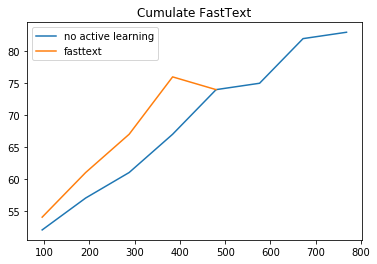

In [30]:
plot_graph(no_active,'no active learning')
plot_graph(fasttext_result,'fasttext')

In [31]:
fasttext_data1 = build_instance("/data/prodigy/data/newsgroup/newgroup_fasttext1.jsonl")
fasttext_result1 = cumulate_train(fasttext_data1,test_data,interval=3,n_iter=20,batch_size=32,emb_dim=300,learning_rate=0.01,cuda_device=-1)


471it [00:05, 83.10it/s] 


FastText Model
No pretrained embedding
embedding weight is trainable
n_iter:  20
vocab_size 50966
emb_dim:  300
learning_rate:  0.01
batch_size:  32
train data size 96
<generator object Module.parameters at 0x7f48c4dbc990>
Time:[1 seconds], batch: [2/3], Epoch: [1/20], step: [1/60], Loss: 0.5632858872413635,Acc:50
Time:[2 seconds], batch: [2/3], Epoch: [2/20], step: [1/60], Loss: 0.4604610502719879,Acc:50
Time:[3 seconds], batch: [2/3], Epoch: [3/20], step: [1/60], Loss: 0.42344510555267334,Acc:50
Time:[4 seconds], batch: [2/3], Epoch: [4/20], step: [1/60], Loss: 0.385511577129364,Acc:50
Time:[5 seconds], batch: [2/3], Epoch: [5/20], step: [1/60], Loss: 0.33114537596702576,Acc:49
Time:[6 seconds], batch: [2/3], Epoch: [6/20], step: [1/60], Loss: 0.2732905447483063,Acc:49
Time:[7 seconds], batch: [2/3], Epoch: [7/20], step: [1/60], Loss: 0.2201443463563919,Acc:49
Time:[9 seconds], batch: [2/3], Epoch: [8/20], step: [1/60], Loss: 0.17087483406066895,Acc:49
Time:[10 seconds], batch: [2/3]

Time:[39 seconds], batch: [11/12], Epoch: [17/20], step: [1/240], Loss: 0.0012331987963989377,Acc:73
Time:[42 seconds], batch: [11/12], Epoch: [18/20], step: [1/240], Loss: 0.0011086341692134738,Acc:73
Time:[44 seconds], batch: [11/12], Epoch: [19/20], step: [1/240], Loss: 0.0010028260294348001,Acc:73
Time:[46 seconds], batch: [11/12], Epoch: [20/20], step: [1/240], Loss: 0.0009120816830545664,Acc:73
FastText Model
No pretrained embedding
embedding weight is trainable
n_iter:  20
vocab_size 50966
emb_dim:  300
learning_rate:  0.01
batch_size:  32
train data size 480
<generator object Module.parameters at 0x7f48c4dbc990>
Time:[2 seconds], batch: [14/15], Epoch: [1/20], step: [1/300], Loss: 0.6272845268249512,Acc:50
Time:[5 seconds], batch: [14/15], Epoch: [2/20], step: [1/300], Loss: 0.4182157814502716,Acc:50
Time:[8 seconds], batch: [14/15], Epoch: [3/20], step: [1/300], Loss: 0.1888137012720108,Acc:60
Time:[11 seconds], batch: [14/15], Epoch: [4/20], step: [1/300], Loss: 0.06204798445

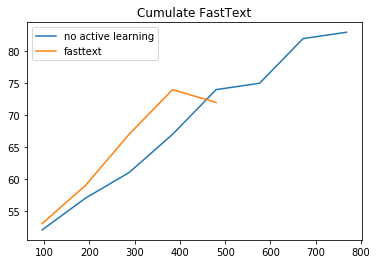

In [32]:
plot_graph(no_active,'no active learning')
plot_graph(fasttext_result1,'fasttext')

### Expand batch size during active learning to 256

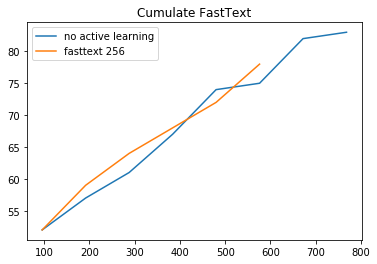

In [75]:
fasttext_data256 = build_instance("/data/prodigy/data/newsgroup/newgroup_fasttext_256.jsonl")
fasttext_result256 = cumulate_train(fasttext_data256,test_data,interval=3,n_iter=20,batch_size=32,emb_dim=300,learning_rate=0.01,cuda_device=-1)

plot_graph(no_active,'no active learning')
plot_graph(fasttext_result256,'fasttext 256')

### Increase batch size during active learning: (10,128,1.3)


0it [00:00, ?it/s]
24it [00:00, 223.20it/s]Exception ignored in: <bound method tqdm.__del__ of 428it [23:06,  3.24s/it]>
Traceback (most recent call last):
  File "/usr/lib/python3.6/site-packages/tqdm/_tqdm.py", line 882, in __del__
    self.close()
  File "/usr/lib/python3.6/site-packages/tqdm/_tqdm.py", line 1087, in close
    self._decr_instances(self)
  File "/usr/lib/python3.6/site-packages/tqdm/_tqdm.py", line 439, in _decr_instances
    cls._instances.remove(instance)
  File "/usr/lib64/python3.6/_weakrefset.py", line 109, in remove
    self.data.remove(ref(item))
KeyError: <weakref at 0x7f45db8c8098; to 'tqdm' at 0x7f45aa8c6e80>

32it [00:00, 69.26it/s] 
38it [00:00, 54.00it/s]
46it [00:00, 57.02it/s]
67it [00:00, 73.57it/s]
90it [00:01, 88.74it/s]
106it [00:01, 80.55it/s]
132it [00:01, 92.99it/s]
148it [00:01, 86.07it/s]
173it [00:01, 95.01it/s]
193it [00:01, 100.40it/s]
212it [00:02, 104.77it/s]
236it [00:02, 108.60it/s]
262it [00:02, 114.89it/s]
285it [00:02, 110.15it/s]
3

FastText Model
No pretrained embedding
embedding weight is trainable
n_iter:  20
vocab_size 50966
emb_dim:  300
learning_rate:  0.01
batch_size:  32
train data size 32
<generator object Module.parameters at 0x7f48c3f226d0>
Time:[0 seconds], batch: [0/1], Epoch: [1/20], step: [1/20], Loss: 0.6836895942687988,Acc:49
Time:[1 seconds], batch: [0/1], Epoch: [2/20], step: [1/20], Loss: 0.5936871767044067,Acc:50
Time:[2 seconds], batch: [0/1], Epoch: [3/20], step: [1/20], Loss: 0.5253111720085144,Acc:50
Time:[3 seconds], batch: [0/1], Epoch: [4/20], step: [1/20], Loss: 0.47451701760292053,Acc:50
Time:[3 seconds], batch: [0/1], Epoch: [5/20], step: [1/20], Loss: 0.43717795610427856,Acc:50
Time:[4 seconds], batch: [0/1], Epoch: [6/20], step: [1/20], Loss: 0.40867435932159424,Acc:50
Time:[5 seconds], batch: [0/1], Epoch: [7/20], step: [1/20], Loss: 0.3840486705303192,Acc:50
Time:[6 seconds], batch: [0/1], Epoch: [8/20], step: [1/20], Loss: 0.3592250943183899,Acc:50
Time:[7 seconds], batch: [0/1]

Time:[21 seconds], batch: [3/4], Epoch: [18/20], step: [1/80], Loss: 0.0025201139505952597,Acc:56
Time:[22 seconds], batch: [3/4], Epoch: [19/20], step: [1/80], Loss: 0.0022238693200051785,Acc:55
Time:[23 seconds], batch: [3/4], Epoch: [20/20], step: [1/80], Loss: 0.0020007898565381765,Acc:55
FastText Model
No pretrained embedding
embedding weight is trainable
n_iter:  20
vocab_size 50966
emb_dim:  300
learning_rate:  0.01
batch_size:  32
train data size 160
<generator object Module.parameters at 0x7f48c3f226d0>
Time:[1 seconds], batch: [4/5], Epoch: [1/20], step: [1/100], Loss: 0.5619286894798279,Acc:50
Time:[2 seconds], batch: [4/5], Epoch: [2/20], step: [1/100], Loss: 0.5334396362304688,Acc:50
Time:[4 seconds], batch: [4/5], Epoch: [3/20], step: [1/100], Loss: 0.462344229221344,Acc:50
Time:[5 seconds], batch: [4/5], Epoch: [4/20], step: [1/100], Loss: 0.35002216696739197,Acc:51
Time:[7 seconds], batch: [4/5], Epoch: [5/20], step: [1/100], Loss: 0.249312624335289,Acc:53
Time:[8 secon

Time:[23 seconds], batch: [7/8], Epoch: [14/20], step: [1/160], Loss: 0.004100808408111334,Acc:66
Time:[25 seconds], batch: [7/8], Epoch: [15/20], step: [1/160], Loss: 0.00360227283090353,Acc:66
Time:[26 seconds], batch: [7/8], Epoch: [16/20], step: [1/160], Loss: 0.0032028346322476864,Acc:66
Time:[28 seconds], batch: [7/8], Epoch: [17/20], step: [1/160], Loss: 0.002874242141842842,Acc:66
Time:[30 seconds], batch: [7/8], Epoch: [18/20], step: [1/160], Loss: 0.0025981911458075047,Acc:66
Time:[31 seconds], batch: [7/8], Epoch: [19/20], step: [1/160], Loss: 0.002362566301599145,Acc:66
Time:[33 seconds], batch: [7/8], Epoch: [20/20], step: [1/160], Loss: 0.002159142168238759,Acc:66
FastText Model
No pretrained embedding
embedding weight is trainable
n_iter:  20
vocab_size 50966
emb_dim:  300
learning_rate:  0.01
batch_size:  32
train data size 288
<generator object Module.parameters at 0x7f48c3f226d0>
Time:[1 seconds], batch: [8/9], Epoch: [1/20], step: [1/180], Loss: 0.6287686228752136,Ac

Time:[20 seconds], batch: [11/12], Epoch: [9/20], step: [1/240], Loss: 0.006057747174054384,Acc:74
Time:[22 seconds], batch: [11/12], Epoch: [10/20], step: [1/240], Loss: 0.00482152821496129,Acc:74
Time:[24 seconds], batch: [11/12], Epoch: [11/20], step: [1/240], Loss: 0.003975457511842251,Acc:74
Time:[26 seconds], batch: [11/12], Epoch: [12/20], step: [1/240], Loss: 0.0033571969252079725,Acc:74
Time:[29 seconds], batch: [11/12], Epoch: [13/20], step: [1/240], Loss: 0.0028832522220909595,Acc:74
Time:[31 seconds], batch: [11/12], Epoch: [14/20], step: [1/240], Loss: 0.0025083429645746946,Acc:74
Time:[33 seconds], batch: [11/12], Epoch: [15/20], step: [1/240], Loss: 0.0022054461296647787,Acc:74
Time:[35 seconds], batch: [11/12], Epoch: [16/20], step: [1/240], Loss: 0.0019566609989851713,Acc:74
Time:[38 seconds], batch: [11/12], Epoch: [17/20], step: [1/240], Loss: 0.00174942915327847,Acc:74
Time:[40 seconds], batch: [11/12], Epoch: [18/20], step: [1/240], Loss: 0.0015746793942525983,Acc:

Time:[9 seconds], batch: [15/16], Epoch: [3/20], step: [1/320], Loss: 0.11903438717126846,Acc:77
Time:[12 seconds], batch: [15/16], Epoch: [4/20], step: [1/320], Loss: 0.042100246995687485,Acc:79
Time:[14 seconds], batch: [15/16], Epoch: [5/20], step: [1/320], Loss: 0.018637346103787422,Acc:78
Time:[18 seconds], batch: [15/16], Epoch: [6/20], step: [1/320], Loss: 0.011300630867481232,Acc:79
Time:[21 seconds], batch: [15/16], Epoch: [7/20], step: [1/320], Loss: 0.007699535693973303,Acc:79
Time:[23 seconds], batch: [15/16], Epoch: [8/20], step: [1/320], Loss: 0.0055745686404407024,Acc:79
Time:[27 seconds], batch: [15/16], Epoch: [9/20], step: [1/320], Loss: 0.004312543664127588,Acc:79
Time:[30 seconds], batch: [15/16], Epoch: [10/20], step: [1/320], Loss: 0.0034768511541187763,Acc:79
Time:[33 seconds], batch: [15/16], Epoch: [11/20], step: [1/320], Loss: 0.0028722374700009823,Acc:79
Time:[35 seconds], batch: [15/16], Epoch: [12/20], step: [1/320], Loss: 0.002417603274807334,Acc:79
Time:[

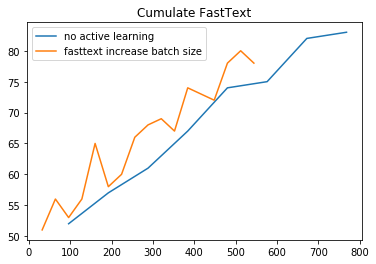

In [85]:
fasttext_data_cb = build_instance("/data/prodigy/data/newsgroup/newgroup_fasttext_cb.jsonl")
fasttext_result_cb = cumulate_train(fasttext_data_cb,test_data,interval=1,n_iter=20,batch_size=32,emb_dim=300,learning_rate=0.01,cuda_device=-1)
plot_graph(no_active,'no active learning')
plot_graph(fasttext_result_cb,'fasttext increase batch size')

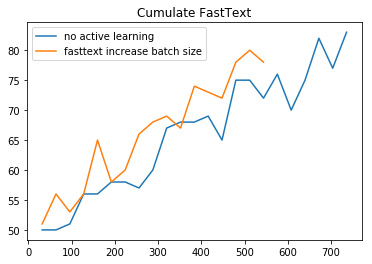

In [89]:
plot_graph(no_active1,'no active learning')
plot_graph(fasttext_result_cb,'fasttext increase batch size')

In [ ]:
def multiplot(ratio_path,times,model,interval,n_iter):
    baseline_data,baseline_y = parse_jsonl(ratio_path)
    data = list(zip(baseline_data,baseline_y))
    active_group = []
    baseline_group = []
    for i in range(times):
        random.shuffle(data)
        baseline_data_ran,baseline_ran_y =zip(*data)
        file_path = '/liveperson/data/alloy/prodigy/data/newsgroup_train'+str(i)+'.jsonl'
        dataset = 'newgroup_log'+str(i)
        print(file_path,dataset)
        save_sample(baseline_data_ran,baseline_ran_y,file_path)
        !python /liveperson/data/alloy/prodigy/code/auto_annotation.py --type newgroup_log --file-path $file_path --dataset $dataset
        !prodigy db-out $dataset /liveperson/data/alloy/prodigy/code/newsgroup
        active_log_data,active_log_y = parse_jsonl("/liveperson/data/alloy/prodigy/code/newsgroup/"+dataset+'.jsonl')
        !prodigy drop $dataset
        
        active_log_x = vectorizer.transform(active_log_data)
        active_result = cumulate_train(model,active_log_x,active_log_y,interval,n_iter)
        plot_active_result = np.array(active_result).reshape((len(active_result),n_iter,3))
        active_group.append(np.max(plot_active_result[:,:,-1],1))
        
        baseline_ran_x = vectorizer.transform(baseline_data_ran)
        baseline_result = cumulate_train(model,baseline_ran_x,baseline_ran_y,interval,n_iter)
        plot_baseline_result = np.array(baseline_result).reshape((len(baseline_result),n_iter,3))
        baseline_group.append(np.max(plot_baseline_result[:,:,-1],1))
    
    max_length = max([len(i) for i in active_group])
    active_group = np.vstack([np.pad(i,(0,max_length-len(i)),mode="constant", constant_values=0) for i in active_group]).transpose()
    active_average_result = np.true_divide(active_group.sum(1),(active_group!=0).sum(1)) 
    baseline_average_result = np.mean(np.vstack(baseline_group).transpose(),1)
    plt.plot(interval*np.arange(1,1+max_length),active_average_result,label='active learning average')
    plt.plot(plot_baseline_result[:,-1,0],baseline_average_result,label='no active learning average')
    plt.title("Average Cumulate "+model+" of "+str(times)+" times")
    plt.legend()
    return active_average_result,baseline_average_result

# plot of rare class

In [81]:
# number of rare class chosen in the active learning process
def plot_rare_class(active_path,baseline_path):
    active_data,active_y = parse_jsonl(active_path)
    baseline_data,baseline_y = parse_jsonl(baseline_path)
    ac_uncertain_plot = [sum(active_y[:i]) for i in range(len(active_y))]
    ba_uncertain_plot = [sum(baseline_y[:i]) for i in range(len(baseline_y))]

    plt.plot(ac_uncertain_plot,label = "active learning")
    plt.plot(ba_uncertain_plot, label = "no active learning")
    plt.legend()
    plt.title("number of rare class chosen in the active learning process")

data size:  471
data size:  749


Text(0.5,1,'number of rare class chosen in the active learning process')

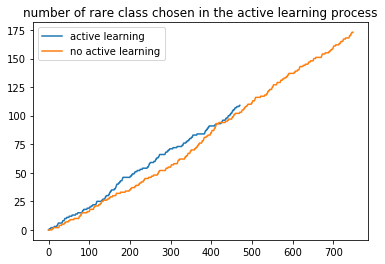

In [38]:
plot_rare_class("/data/prodigy/data/newsgroup/newgroup_fasttext1.jsonl","/data/prodigy/data/newsgroup/newsgroup_train.jsonl"):

data size:  544
data size:  749


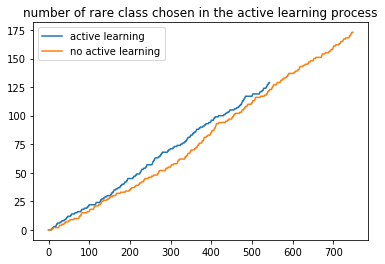

In [82]:
plot_rare_class("/data/prodigy/data/newsgroup/newgroup_fasttext_cb.jsonl","/data/prodigy/data/newsgroup/newsgroup_train.jsonl")
    

# Score Distribution

In [103]:
# compare score distribution before train and after train

def prediction(model,test_loader):
    predict_score = []
    model.eval()
    for batch_idx,batch in enumerate(test_loader):
        data_batch = Variable(batch['text']['tokens'])
        labels = batch['label']
        length_batch = Variable(batch['length'])
        outputs = model(data_batch, length_batch)
        predict_score += outputs.data.tolist()
    model.train()
    return predict_score
def plot_score_distribution(n_iter,file_path,title):
    #file_path ="/data/prodigy/data/newsgroup/newsgroup_train.jsonl"
    data = build_instance(file_path)
    train_loader = batchify(data,vocab,32,False,-1)
    ft_model = FastText(emb_dim=300,vocab_size=50966) 
    fasttext_result,ft_model = single_train(ft_model,train_loader,test_loader,n_iter=n_iter,vocab_size=vocab.get_vocab_size(),emb_dim=300,learning_rate=0.01,data_size=len(fasttext_data),batch_size=32)
    initial_model = FastText(emb_dim=300,vocab_size=50966) 
    ft_score = prediction(initial_model,test_loader)
    ft_score_train = prediction(ft_model,test_loader)

    fig =plt.figure(figsize=(10,5))
    plt.xlim((0,1))
    plt.hist(ft_score,bins=100,label="before training")
    plt.hist(ft_score_train,bins=100,label = "after training")
    plt.legend()
    plt.title(title)


0it [00:00, ?it/s]
2it [00:00, 14.26it/s]
25it [00:00, 104.07it/s]
40it [00:00, 107.51it/s]
68it [00:00, 143.26it/s]
93it [00:00, 161.73it/s]
111it [00:00, 125.83it/s]
125it [00:01, 110.14it/s]
154it [00:01, 124.22it/s]
171it [00:01, 112.90it/s]
196it [00:01, 121.12it/s]
220it [00:01, 115.06it/s]
235it [00:02, 115.12it/s]
249it [00:02, 107.45it/s]
271it [00:02, 112.06it/s]
286it [00:02, 97.77it/s] 
311it [00:03, 102.78it/s]
326it [00:03, 102.11it/s]
347it [00:03, 104.96it/s]
372it [00:03, 109.14it/s]
390it [00:03, 104.43it/s]
404it [00:04, 96.42it/s] 
415it [00:04, 92.96it/s]
424it [00:04, 85.57it/s]
433it [00:05, 82.63it/s]
455it [00:05, 85.16it/s]
466it [00:05, 81.34it/s]
471it [00:05, 81.79it/s]
 88%|████████▊ | 416/471 [00:00<00:00, 721.28it/s]
                                                  

FastText Model
No pretrained embedding
embedding weight is trainable
n_iter:  1
vocab_size 50966
emb_dim:  300
learning_rate:  0.01
batch_size:  32
train data size 478
<generator object Module.parameters at 0x7f46a8031258>
Time:[2 seconds], batch: [14/14], Epoch: [1/1], step: [1/14], Loss: 0.6186074614524841,Acc:50
FastText Model


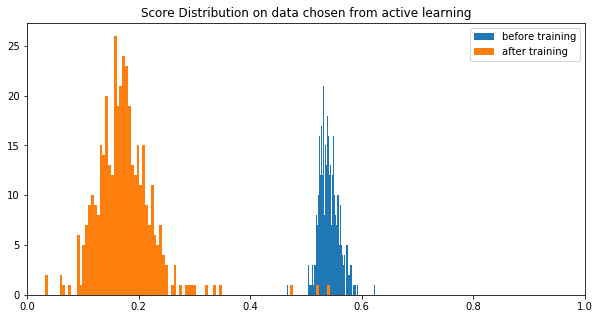

In [106]:
plot_score_distribution(1,"/data/prodigy/data/newsgroup/newgroup_fasttext1.jsonl","Score Distribution on data chosen from active learning")



0it [00:00, ?it/s]
2it [00:00, 14.57it/s]
26it [00:00, 108.77it/s]
40it [00:00, 111.38it/s]
69it [00:00, 150.02it/s]
94it [00:00, 167.85it/s]
112it [00:00, 129.30it/s]
127it [00:01, 113.00it/s]
155it [00:01, 126.50it/s]
172it [00:01, 114.84it/s]
196it [00:01, 122.51it/s]
220it [00:01, 116.28it/s]
234it [00:02, 115.97it/s]
248it [00:02, 108.04it/s]
271it [00:02, 112.91it/s]
286it [00:02, 98.44it/s] 
312it [00:03, 103.72it/s]
328it [00:03, 103.03it/s]
347it [00:03, 105.56it/s]
371it [00:03, 109.52it/s]
389it [00:03, 104.78it/s]
403it [00:04, 96.21it/s] 
415it [00:04, 92.89it/s]
424it [00:04, 85.57it/s]
433it [00:05, 82.58it/s]
455it [00:05, 85.11it/s]
466it [00:05, 81.27it/s]
471it [00:05, 81.71it/s]
 88%|████████▊ | 416/471 [00:00<00:00, 720.63it/s]
                                                  

FastText Model
No pretrained embedding
embedding weight is trainable
n_iter:  20
vocab_size 50966
emb_dim:  300
learning_rate:  0.01
batch_size:  32
train data size 478
<generator object Module.parameters at 0x7f4545fc1990>
Time:[2 seconds], batch: [14/14], Epoch: [1/20], step: [1/298], Loss: 0.6170650720596313,Acc:50
Time:[5 seconds], batch: [14/14], Epoch: [2/20], step: [1/298], Loss: 0.3976826071739197,Acc:51
Time:[8 seconds], batch: [14/14], Epoch: [3/20], step: [1/298], Loss: 0.1711772084236145,Acc:59
Time:[11 seconds], batch: [14/14], Epoch: [4/20], step: [1/298], Loss: 0.054329682141542435,Acc:63
Time:[14 seconds], batch: [14/14], Epoch: [5/20], step: [1/298], Loss: 0.01875801384449005,Acc:68
Time:[17 seconds], batch: [14/14], Epoch: [6/20], step: [1/298], Loss: 0.010294303297996521,Acc:67
Time:[20 seconds], batch: [14/14], Epoch: [7/20], step: [1/298], Loss: 0.0067385109141469,Acc:68
Time:[23 seconds], batch: [14/14], Epoch: [8/20], step: [1/298], Loss: 0.004787424113601446,Acc

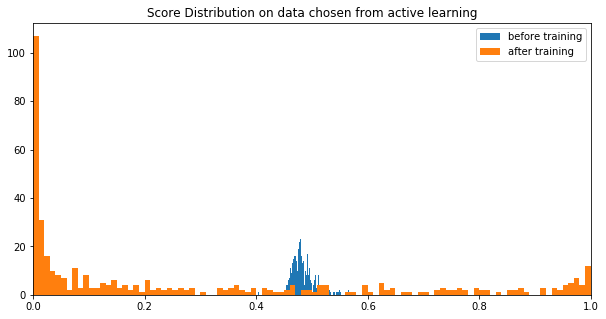

In [107]:
plot_score_distribution(20,"/data/prodigy/data/newsgroup/newgroup_fasttext1.jsonl","Score Distribution on data chosen from active learning")



0it [00:00, ?it/s]
23it [00:00, 222.61it/s]
38it [00:00, 102.37it/s]
46it [00:00, 96.87it/s] 
67it [00:00, 116.07it/s]
90it [00:00, 132.56it/s]
106it [00:00, 108.31it/s]
133it [00:01, 123.20it/s]
150it [00:01, 108.64it/s]
175it [00:01, 118.03it/s]
197it [00:01, 124.34it/s]
217it [00:01, 128.67it/s]
236it [00:01, 129.99it/s]
262it [00:01, 136.74it/s]
285it [00:02, 128.73it/s]
302it [00:02, 119.86it/s]
324it [00:02, 123.60it/s]
345it [00:02, 126.60it/s]
366it [00:02, 129.47it/s]
384it [00:03, 126.51it/s]
406it [00:03, 129.44it/s]
424it [00:03, 123.82it/s]
438it [00:03, 113.31it/s]
449it [00:04, 109.11it/s]
458it [00:04, 96.07it/s] 
465it [00:04, 94.58it/s]
478it [00:05, 92.13it/s]
498it [00:05, 94.16it/s]
508it [00:05, 91.49it/s]
524it [00:05, 91.16it/s]
542it [00:05, 92.64it/s]
544it [00:05, 92.59it/s]
 94%|█████████▍| 512/544 [00:00<00:00, 711.98it/s]
                                                  

FastText Model
No pretrained embedding
embedding weight is trainable
n_iter:  1
vocab_size 50966
emb_dim:  300
learning_rate:  0.01
batch_size:  32
train data size 478
<generator object Module.parameters at 0x7f4545fc1e60>
Time:[3 seconds], batch: [16/14], Epoch: [1/1], step: [1/14], Loss: 0.6928684711456299,Acc:50
FastText Model


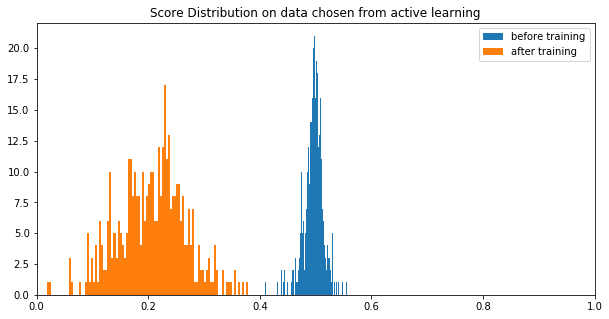

In [104]:
plot_score_distribution(1,"/data/prodigy/data/newsgroup/newgroup_fasttext_cb.jsonl","Score Distribution on data chosen from active learning")



0it [00:00, ?it/s]
23it [00:00, 223.57it/s]
38it [00:00, 99.93it/s] 
45it [00:00, 93.08it/s]
65it [00:00, 110.74it/s]
88it [00:00, 128.06it/s]
106it [00:01, 104.62it/s]
131it [00:01, 117.41it/s]
148it [00:01, 103.54it/s]
173it [00:01, 113.02it/s]
193it [00:01, 117.63it/s]
211it [00:01, 120.97it/s]
235it [00:01, 127.40it/s]
255it [00:01, 128.42it/s]
278it [00:02, 133.26it/s]
298it [00:02, 114.94it/s]
319it [00:02, 118.40it/s]
340it [00:02, 121.51it/s]
361it [00:02, 124.46it/s]
380it [00:03, 122.61it/s]
402it [00:03, 125.62it/s]
420it [00:03, 120.29it/s]
435it [00:03, 110.21it/s]
449it [00:04, 106.75it/s]
459it [00:04, 103.22it/s]
467it [00:04, 101.63it/s]
478it [00:04, 98.31it/s] 
498it [00:04, 100.33it/s]
509it [00:05, 97.22it/s] 
524it [00:05, 96.61it/s]
542it [00:05, 98.06it/s]
544it [00:05, 97.99it/s]
 94%|█████████▍| 512/544 [00:00<00:00, 688.39it/s]
                                                  

FastText Model
No pretrained embedding
embedding weight is trainable
n_iter:  20
vocab_size 50966
emb_dim:  300
learning_rate:  0.01
batch_size:  32
train data size 478
<generator object Module.parameters at 0x7f48c34f2d58>
Time:[3 seconds], batch: [16/14], Epoch: [1/20], step: [1/298], Loss: 0.6488977670669556,Acc:50
Time:[6 seconds], batch: [16/14], Epoch: [2/20], step: [1/298], Loss: 0.5320686101913452,Acc:53
Time:[9 seconds], batch: [16/14], Epoch: [3/20], step: [1/298], Loss: 0.25513964891433716,Acc:70
Time:[12 seconds], batch: [16/14], Epoch: [4/20], step: [1/298], Loss: 0.11117855459451675,Acc:74
Time:[15 seconds], batch: [16/14], Epoch: [5/20], step: [1/298], Loss: 0.04236837103962898,Acc:76
Time:[18 seconds], batch: [16/14], Epoch: [6/20], step: [1/298], Loss: 0.03763846307992935,Acc:74
Time:[21 seconds], batch: [16/14], Epoch: [7/20], step: [1/298], Loss: 0.016566220670938492,Acc:76
Time:[25 seconds], batch: [16/14], Epoch: [8/20], step: [1/298], Loss: 0.011559850536286831,Ac

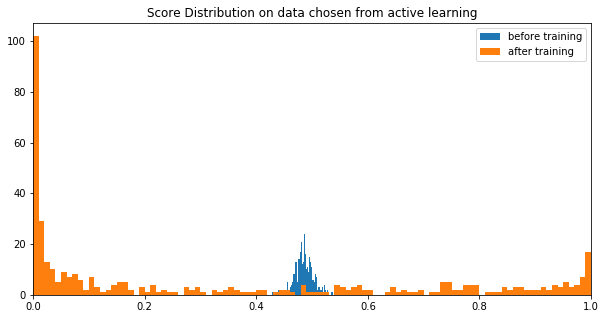

In [105]:
plot_score_distribution(20,"/data/prodigy/data/newsgroup/newgroup_fasttext_cb.jsonl","Score Distribution on data chosen from active learning")


Text(0.5,1,'Score Distribution on whole data')

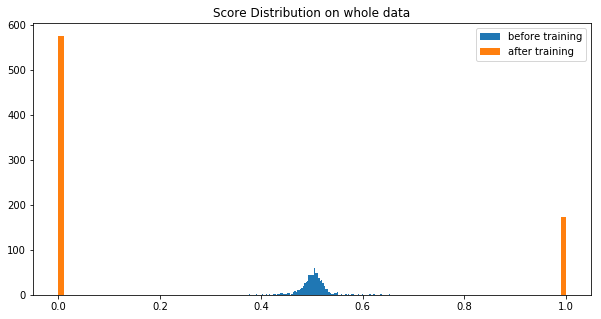

In [71]:
fig =plt.figure(figsize=(10,5))
plt.hist(ft_score,bins=100,label="before training")
plt.hist(ft_score_train,bins=100,label = "after training")
plt.legend()
plt.title("Score Distribution on whole data")

In [59]:
ft_model = FastText(emb_dim=300,vocab_size=50966) 
fasttext_result,ft_model = single_train(ft_model,train_loader,test_loader,n_iter=20,vocab_size=vocab.get_vocab_size(),emb_dim=300,learning_rate=0.01,data_size=len(fasttext_data),batch_size=32)
ft_score = plot_score_distribution(ft_model)

FastText Model
No pretrained embedding
embedding weight is trainable
n_iter:  20
vocab_size 50966
emb_dim:  300
learning_rate:  0.01
batch_size:  32
train data size 478
<generator object Module.parameters at 0x7f48c3d34af0>
Time:[4 seconds], batch: [23/14], Epoch: [1/20], step: [1/298], Loss: 0.670076310634613,Acc:50
Time:[8 seconds], batch: [23/14], Epoch: [2/20], step: [1/298], Loss: 0.37632450461387634,Acc:61
Time:[12 seconds], batch: [23/14], Epoch: [3/20], step: [1/298], Loss: 0.1067628487944603,Acc:73
Time:[16 seconds], batch: [23/14], Epoch: [4/20], step: [1/298], Loss: 0.030162181705236435,Acc:74
Time:[20 seconds], batch: [23/14], Epoch: [5/20], step: [1/298], Loss: 0.011937763541936874,Acc:72
Time:[24 seconds], batch: [23/14], Epoch: [6/20], step: [1/298], Loss: 0.009273755364120007,Acc:73
Time:[29 seconds], batch: [23/14], Epoch: [7/20], step: [1/298], Loss: 0.005752124823629856,Acc:73
Time:[33 seconds], batch: [23/14], Epoch: [8/20], step: [1/298], Loss: 0.004644796717911959

 21%|██▏       | 160/749 [00:00<00:00, 1557.31it/s]

Time:[82 seconds], batch: [23/14], Epoch: [20/20], step: [1/298], Loss: 0.0007718484266661108,Acc:75


In [ ]:
fasttext_result,ft_model = single_train(ft_model,train_loader,test_loader,n_iter=20,vocab_size=vocab.get_vocab_size(),emb_dim=300,learning_rate=0.01,data_size=len(fasttext_data),batch_size=32)

Text(0.5,1,'Score Distribution on data chosen from active learning')

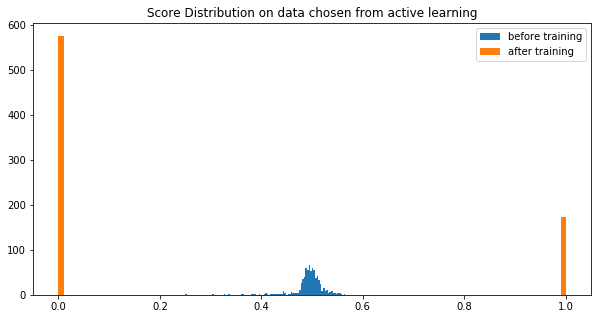

In [61]:
fig =plt.figure(figsize=(10,5))
plt.hist(predict_score,bins=100,label="before training")
plt.hist(ft_score,bins=100,label = "after training")
plt.legend()
plt.title("Score Distribution on data chosen from active learning")

# Probability Calibration

In [48]:
# plot calibration probability graph for fasttext
def fasttext_calplot(test_loader,file_path):
    fig = plt.figure(1, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    
    
    
    ft_model = FastText(emb_dim=300,vocab_size=50966)
    fasttext_data = build_instance(file_path)
    train_loader = batchify(fasttext_data,vocab,32,False,-1)
    # train the model with whole data
    fasttext_result,ft_model = single_train(ft_model,train_loader,test_loader,n_iter=20,vocab_size=vocab.get_vocab_size(),emb_dim=300,learning_rate=0.01,data_size=len(fasttext_data),batch_size=32)
    # generate prob_list
    prob_list = []
    ft_model.eval()
    for batch_idx,batch in enumerate(test_loader):
        data_batch = Variable(batch['text']['tokens'])
        labels = batch['label']
        length_batch = Variable(batch['length'])
        prob_list+= ft_model(data_batch, length_batch).tolist()
    ft_model.train()
    # generate true test_label
    test_label=[]
    for d in test_loader:
        test_label += d['label'].tolist()
    # draw the graph
    clf_score = brier_score_loss(test_label, prob_list, pos_label=1)
    fraction_of_positives, mean_predicted_value = \
            calibration_curve(test_label,prob_list, n_bins=10)
    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s (%1.3f)" % ("FastText", clf_score))
    ax2.hist(prob_list, range=(0, 1), bins=10, label="FastText",
             histtype="step", lw=2)
    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)
    
    plt.tight_layout()

0it [00:00, ?it/s]                                 

FastText Model


471it [00:05, 83.50it/s] 


No pretrained embedding
embedding weight is trainable
n_iter:  20
vocab_size 50966
emb_dim:  300
learning_rate:  0.01
batch_size:  32
train data size 471
<generator object Module.parameters at 0x7f48c3d34468>
Time:[2 seconds], batch: [14/14], Epoch: [1/20], step: [1/294], Loss: 0.6058338284492493,Acc:50
Time:[5 seconds], batch: [14/14], Epoch: [2/20], step: [1/294], Loss: 0.4022611975669861,Acc:50
Time:[8 seconds], batch: [14/14], Epoch: [3/20], step: [1/294], Loss: 0.18200752139091492,Acc:63
Time:[11 seconds], batch: [14/14], Epoch: [4/20], step: [1/294], Loss: 0.06052842736244202,Acc:67
Time:[14 seconds], batch: [14/14], Epoch: [5/20], step: [1/294], Loss: 0.02015378512442112,Acc:72
Time:[17 seconds], batch: [14/14], Epoch: [6/20], step: [1/294], Loss: 0.010602944530546665,Acc:72
Time:[20 seconds], batch: [14/14], Epoch: [7/20], step: [1/294], Loss: 0.006779045332223177,Acc:72
Time:[23 seconds], batch: [14/14], Epoch: [8/20], step: [1/294], Loss: 0.0047746095806360245,Acc:74
Time:[26

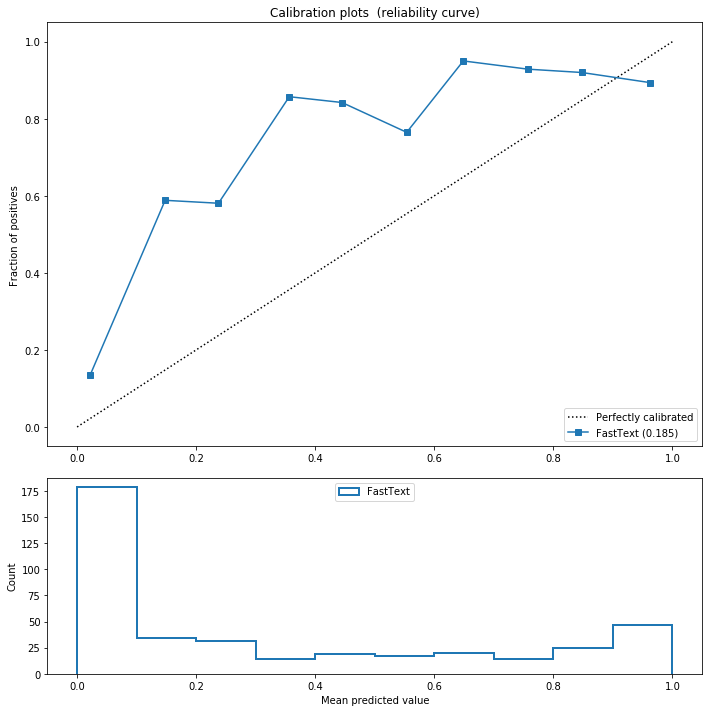

In [49]:

test_loader = batchify(test_data,vocab,32,False,-1)
fasttext_calplot(test_loader,"/data/prodigy/data/newsgroup/newgroup_fasttext1.jsonl")

0it [00:00, ?it/s]

FastText Model


749it [00:07, 98.33it/s] 


No pretrained embedding
embedding weight is trainable
n_iter:  20
vocab_size 50966
emb_dim:  300
learning_rate:  0.01
batch_size:  32
train data size 749
<generator object Module.parameters at 0x7f48c3c6f780>
Time:[4 seconds], batch: [23/23], Epoch: [1/20], step: [1/468], Loss: 0.6890318989753723,Acc:51
Time:[8 seconds], batch: [23/23], Epoch: [2/20], step: [1/468], Loss: 0.40629687905311584,Acc:69
Time:[12 seconds], batch: [23/23], Epoch: [3/20], step: [1/468], Loss: 0.13114199042320251,Acc:83
Time:[16 seconds], batch: [23/23], Epoch: [4/20], step: [1/468], Loss: 0.03430548310279846,Acc:84
Time:[20 seconds], batch: [23/23], Epoch: [5/20], step: [1/468], Loss: 0.013019004836678505,Acc:81
Time:[24 seconds], batch: [23/23], Epoch: [6/20], step: [1/468], Loss: 0.00878395326435566,Acc:82
Time:[28 seconds], batch: [23/23], Epoch: [7/20], step: [1/468], Loss: 0.006297817453742027,Acc:82
Time:[32 seconds], batch: [23/23], Epoch: [8/20], step: [1/468], Loss: 0.004745589569211006,Acc:81
Time:[3

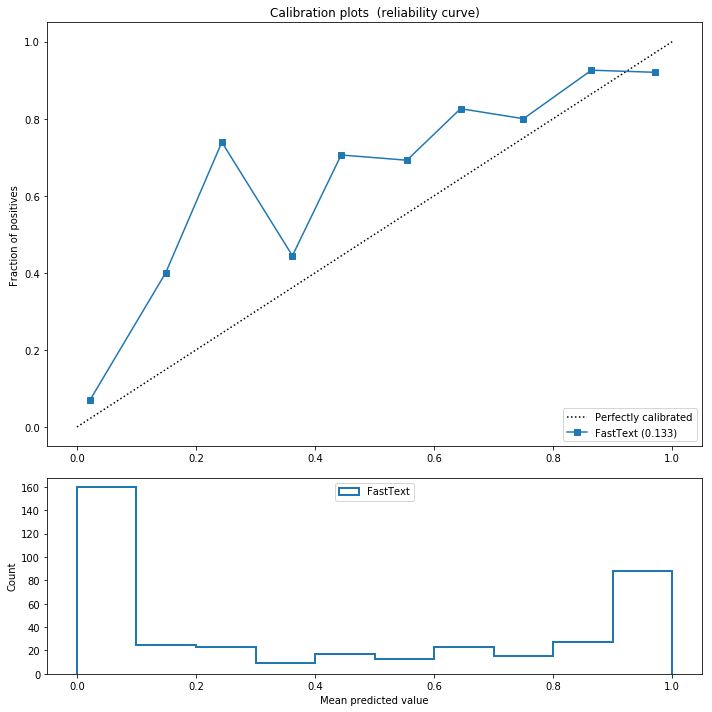

In [50]:
fasttext_calplot(test_loader,"/data/prodigy/data/newsgroup/newsgroup_train.jsonl")

## Experiment on Balanced data

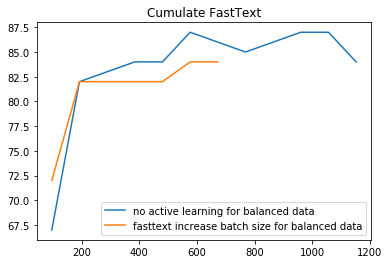

In [98]:
fasttext_data_balance = build_instance("/data/prodigy/data/newsgroup/newgroup_fasttext_balance.jsonl")
fasttext_result_balance = cumulate_train(fasttext_data_balance,test_data,interval=3,n_iter=20,batch_size=32,emb_dim=300,learning_rate=0.01,cuda_device=-1)


baseline_data_balance = build_instance("/data/prodigy/data/newsgroup/newsgroup_train_balance.jsonl")
no_active_balance = cumulate_train(baseline_data_balance,test_data,interval=3,n_iter=20,batch_size=32,emb_dim=300,learning_rate=0.01,cuda_device=-1)



plot_graph(no_active_balance,'no active learning for balanced data')
plot_graph(fasttext_result_balance,'fasttext increase batch size for balanced data')


0it [00:00, ?it/s]
23it [00:00, 211.45it/s]
46it [00:00, 204.84it/s]
70it [00:00, 216.06it/s]
85it [00:00, 106.70it/s]
97it [00:01, 90.57it/s] 
107it [00:01, 83.77it/s]
125it [00:01, 78.49it/s]
147it [00:01, 86.80it/s]
159it [00:01, 82.17it/s]
169it [00:02, 77.19it/s]
181it [00:02, 79.05it/s]
191it [00:02, 74.49it/s]
209it [00:02, 78.38it/s]
220it [00:02, 77.35it/s]
239it [00:02, 81.18it/s]
258it [00:03, 84.71it/s]
280it [00:03, 88.96it/s]
305it [00:03, 93.92it/s]
330it [00:03, 98.55it/s]
356it [00:03, 103.14it/s]
379it [00:03, 103.43it/s]
398it [00:03, 104.63it/s]
420it [00:03, 107.52it/s]
445it [00:04, 110.97it/s]
466it [00:04, 113.35it/s]
487it [00:04, 115.43it/s]
509it [00:04, 117.80it/s]
534it [00:04, 120.53it/s]
556it [00:04, 120.68it/s]
576it [00:04, 122.32it/s]
600it [00:04, 124.64it/s]
621it [00:04, 126.14it/s]
641it [00:05, 122.53it/s]
665it [00:05, 124.68it/s]
685it [00:05, 125.97it/s]
705it [00:05, 127.14it/s]
724it [00:06, 115.88it/s]
738it [00:06, 115.98it/s]
752it [00:0

FastText Model
No pretrained embedding
embedding weight is trainable
n_iter:  20
vocab_size 50966
emb_dim:  300
learning_rate:  0.01
batch_size:  32
train data size 96
<generator object Module.parameters at 0x7f4545fc1e60>
Time:[1 seconds], batch: [2/3], Epoch: [1/20], step: [1/60], Loss: 0.6754698753356934,Acc:64
Time:[2 seconds], batch: [2/3], Epoch: [2/20], step: [1/60], Loss: 0.6142275929450989,Acc:58
Time:[3 seconds], batch: [2/3], Epoch: [3/20], step: [1/60], Loss: 0.5545895099639893,Acc:63
Time:[4 seconds], batch: [2/3], Epoch: [4/20], step: [1/60], Loss: 0.4785919189453125,Acc:70
Time:[5 seconds], batch: [2/3], Epoch: [5/20], step: [1/60], Loss: 0.39264705777168274,Acc:70
Time:[6 seconds], batch: [2/3], Epoch: [6/20], step: [1/60], Loss: 0.304779976606369,Acc:72
Time:[7 seconds], batch: [2/3], Epoch: [7/20], step: [1/60], Loss: 0.2222220003604889,Acc:71
Time:[8 seconds], batch: [2/3], Epoch: [8/20], step: [1/60], Loss: 0.15345992147922516,Acc:72
Time:[9 seconds], batch: [2/3], 

Time:[38 seconds], batch: [11/12], Epoch: [17/20], step: [1/240], Loss: 0.0017752237617969513,Acc:82
Time:[40 seconds], batch: [11/12], Epoch: [18/20], step: [1/240], Loss: 0.0015973339322954416,Acc:82
Time:[42 seconds], batch: [11/12], Epoch: [19/20], step: [1/240], Loss: 0.001445736619643867,Acc:82
Time:[45 seconds], batch: [11/12], Epoch: [20/20], step: [1/240], Loss: 0.0013154284097254276,Acc:83
FastText Model
No pretrained embedding
embedding weight is trainable
n_iter:  20
vocab_size 50966
emb_dim:  300
learning_rate:  0.01
batch_size:  32
train data size 480
<generator object Module.parameters at 0x7f4545fc1e60>
Time:[2 seconds], batch: [14/15], Epoch: [1/20], step: [1/300], Loss: 0.6212875247001648,Acc:67
Time:[4 seconds], batch: [14/15], Epoch: [2/20], step: [1/300], Loss: 0.3957287073135376,Acc:81
Time:[7 seconds], batch: [14/15], Epoch: [3/20], step: [1/300], Loss: 0.1652466356754303,Acc:81
Time:[9 seconds], batch: [14/15], Epoch: [4/20], step: [1/300], Loss: 0.0656351298093

Time:[38 seconds], batch: [23/24], Epoch: [11/20], step: [1/480], Loss: 0.004063076339662075,Acc:82
Time:[42 seconds], batch: [23/24], Epoch: [12/20], step: [1/480], Loss: 0.003468842012807727,Acc:82
Time:[46 seconds], batch: [23/24], Epoch: [13/20], step: [1/480], Loss: 0.0030003520660102367,Acc:82
Time:[49 seconds], batch: [23/24], Epoch: [14/20], step: [1/480], Loss: 0.0026245489716529846,Acc:82
Time:[52 seconds], batch: [23/24], Epoch: [15/20], step: [1/480], Loss: 0.0023178462870419025,Acc:82
Time:[56 seconds], batch: [23/24], Epoch: [16/20], step: [1/480], Loss: 0.002063858089968562,Acc:82
Time:[59 seconds], batch: [23/24], Epoch: [17/20], step: [1/480], Loss: 0.0018509103683754802,Acc:82
Time:[63 seconds], batch: [23/24], Epoch: [18/20], step: [1/480], Loss: 0.0016704329755157232,Acc:82
Time:[66 seconds], batch: [23/24], Epoch: [19/20], step: [1/480], Loss: 0.0015160023467615247,Acc:82
Time:[70 seconds], batch: [23/24], Epoch: [20/20], step: [1/480], Loss: 0.001382691552862525,A

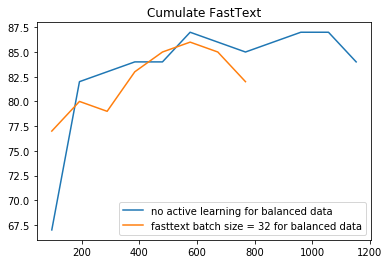

In [102]:
fasttext_data_balance_32 = build_instance("/data/prodigy/data/newsgroup/newgroup_fasttext_balance_32.jsonl")
fasttext_result_balance_32 = cumulate_train(fasttext_data_balance_32,test_data,interval=3,n_iter=20,batch_size=32,emb_dim=300,learning_rate=0.01,cuda_device=-1)


# baseline_data_balance = build_instance("/data/prodigy/data/newsgroup/newsgroup_train_balance.jsonl")
# no_active_balance = cumulate_train(baseline_data_balance,test_data,interval=3,n_iter=20,batch_size=32,emb_dim=300,learning_rate=0.01,cuda_device=-1)



plot_graph(no_active_balance,'no active learning for balanced data')
plot_graph(fasttext_result_balance_32,'fasttext batch size = 32 for balanced data')